In [1]:
import numpy as np
import pandas as pd
import os
import sys
import gc
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

在这一部分中，将进行以下三个部分的工作：
* 特征选择
* 模型选择
* 模型超参数优化

## 1 特征选择
导入在上一节中已经提取到的特征数据集

In [2]:
all_data = pd.read_csv("../data/all_engineered.csv")

查看数据类型

In [3]:
Id = all_data['SK_ID_CURR']
Target = all_data['TARGET']
all_data = all_data.drop(columns=['SK_ID_CURR','TARGET'])

In [4]:
print(all_data.shape)

(356255, 880)


经过我们上一步的数据提取，已经得到一个包含880维特征的预测特征数据集，这些特征之间可能存在高度共线性，也可能存在缺失比例过高等情况，在后续的特征选择的过程中，我们都需要注重关注这些情况。

In [5]:
display(all_data.dtypes.value_counts())

float64    704
int64      176
dtype: int64

检查一下，是否有ID类的组合特征

In [6]:
cols_with_id = [x for x in all_data.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in all_data.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in all_data.columns if 'SK_ID_PREV' in x]
print('There are {} columns that contain SK_ID_CURR'.format(len(cols_with_id)))
print('There are {} columns that contain SK_ID_BUREAU'.format(len(cols_with_bureau_id)))
print('There are {} columns that contain SK_ID_PREV'.format(len(cols_with_previous_id)))

There are 0 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV


计算特征之间的共线性，如果以完整数据集计算的话，会非常的耗时，因此，这里仅抽样了10000条数据，大致估计特征之间的线性相关性系数。

In [7]:
threshold = 0.9
corr_matrix = all_data.sample(10000).corr().abs()
corr_matrix.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,PREVIOUS_AMT_APPLICATION_sum,PREVIOUS_DAYS_FIRST_DRAWING_min,PREVIOUS_DAYS_FIRST_DRAWING_mean,PREVIOUS_DAYS_FIRST_DRAWING_max,PREVIOUS_RATE_INTEREST_PRIMARY_min,PREVIOUS_RATE_INTEREST_PRIMARY_mean,PREVIOUS_RATE_INTEREST_PRIMARY_max,PREVIOUS_RATE_INTEREST_PRIVILEGED_min,PREVIOUS_RATE_INTEREST_PRIVILEGED_mean,PREVIOUS_RATE_INTEREST_PRIVILEGED_max
AMT_ANNUITY,1.000000,0.764551,0.769956,0.036592,0.002343,0.014115,0.025148,0.014171,0.004642,0.023894,...,0.110532,0.095331,0.095870,0.096294,0.016282,0.018063,0.019842,0.030728,0.036263,0.041752
AMT_CREDIT,0.764551,1.000000,0.986834,0.029969,0.003697,0.004921,0.058421,0.006255,0.007055,0.059139,...,0.104095,0.154765,0.155780,0.156607,0.019407,0.021000,0.022591,0.145764,0.150757,0.155529
AMT_GOODS_PRICE,0.769956,0.986834,1.000000,0.029258,0.004279,0.005165,0.061678,0.004264,0.006369,0.060406,...,0.106582,0.155953,0.156884,0.157626,0.011076,0.012617,0.014157,0.165286,0.170091,0.174647
AMT_INCOME_TOTAL,0.036592,0.029969,0.029258,1.000000,0.000072,0.001299,0.001082,0.004360,0.001336,0.002897,...,0.012086,0.018548,0.018949,0.019328,0.003224,0.003098,0.002972,0.083446,0.083174,0.082776
AMT_REQ_CREDIT_BUREAU_DAY,0.002343,0.003697,0.004279,0.000072,1.000000,0.186542,0.006920,0.011064,0.339726,0.021164,...,0.007431,0.021395,0.021305,0.021185,0.035135,0.035344,0.035549,0.051534,0.052309,0.052995


In [8]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
upper.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,PREVIOUS_AMT_APPLICATION_sum,PREVIOUS_DAYS_FIRST_DRAWING_min,PREVIOUS_DAYS_FIRST_DRAWING_mean,PREVIOUS_DAYS_FIRST_DRAWING_max,PREVIOUS_RATE_INTEREST_PRIMARY_min,PREVIOUS_RATE_INTEREST_PRIMARY_mean,PREVIOUS_RATE_INTEREST_PRIMARY_max,PREVIOUS_RATE_INTEREST_PRIVILEGED_min,PREVIOUS_RATE_INTEREST_PRIVILEGED_mean,PREVIOUS_RATE_INTEREST_PRIVILEGED_max
AMT_ANNUITY,NaN,0.764551,0.769956,0.036592,0.002343,0.014115,0.025148,0.014171,0.004642,0.023894,...,0.110532,0.095331,0.095870,0.096294,0.016282,0.018063,0.019842,0.030728,0.036263,0.041752
AMT_CREDIT,NaN,NaN,0.986834,0.029969,0.003697,0.004921,0.058421,0.006255,0.007055,0.059139,...,0.104095,0.154765,0.155780,0.156607,0.019407,0.021000,0.022591,0.145764,0.150757,0.155529
AMT_GOODS_PRICE,NaN,NaN,NaN,0.029258,0.004279,0.005165,0.061678,0.004264,0.006369,0.060406,...,0.106582,0.155953,0.156884,0.157626,0.011076,0.012617,0.014157,0.165286,0.170091,0.174647
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.000072,0.001299,0.001082,0.004360,0.001336,0.002897,...,0.012086,0.018548,0.018949,0.019328,0.003224,0.003098,0.002972,0.083446,0.083174,0.082776
AMT_REQ_CREDIT_BUREAU_DAY,NaN,NaN,NaN,NaN,NaN,0.186542,0.006920,0.011064,0.339726,0.021164,...,0.007431,0.021395,0.021305,0.021185,0.035135,0.035344,0.035549,0.051534,0.052309,0.052995


In [9]:
to_drop = [column for column in upper.columns if any(upper[column]>threshold)]
print('There are {} columns to remove.'.format(len(to_drop)))

There are 184 columns to remove.


从1000条样本的估计结果来看，有186组特征之间存在着高于90%的线性相关性。这些两两的特征组合中，需求删除其中一个，仅留下其中一个。

In [10]:
all_data = all_data.drop(columns=to_drop)
print('all_data shape: {}'.format(all_data.shape))

all_data shape: (356255, 696)


删除缺失率高于60%的特征

In [11]:
data_missing = (all_data.isnull().sum() / len(all_data)).sort_values(ascending = False)
data_missing.head()

PREVIOUS_RATE_INTEREST_PRIVILEGED_min    0.983941
COMMONAREA_AVG                           0.697141
NONLIVINGAPARTMENTS_AVG                  0.692933
FLOORSMIN_AVG                            0.676785
BUREAU_LOAN_RATE_min                     0.669316
dtype: float64

In [12]:
data_missing = data_missing.index[data_missing > 0.60]

In [13]:
data_missing = list(data_missing)
print('There are {} columns with more than 60% missing values'.format(len(data_missing)))

There are 100 columns with more than 60% missing values


In [14]:
all_data = all_data.drop(columns=data_missing)
print('Data set full shape: {}'.format(all_data.shape))

Data set full shape: (356255, 596)


经过这样简单的特征选择之后，最终的预测特征还有592维。

In [15]:
miss_ratios = all_data.isnull().mean()

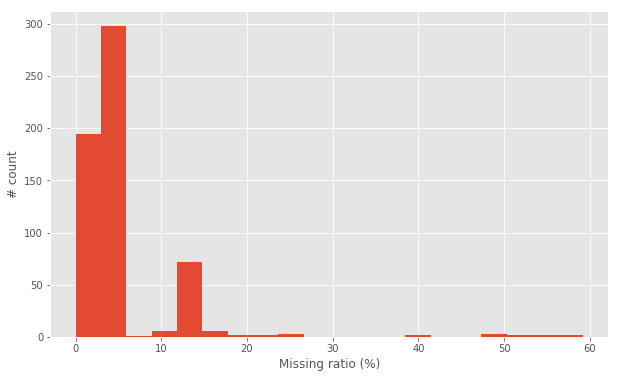

In [16]:
plt.figure(figsize=(10,6))
plt.hist(miss_ratios.values*100,bins=20)
plt.xlabel('Missing ratio (%)')
plt.ylabel('# count')
plt.show()

In [17]:
all_data.dtypes[miss_ratios>0].value_counts()

float64    410
dtype: int64

仍然存在缺失情况的特征有406维，不过从上图中也看到，大部分的数据缺失比例已经不高了，控制在了15%以内。现阶段，我们采取以0填补缺失值的方式，有时间的话可以做更加细致的分析。

In [18]:
all_data = all_data.fillna(0)

In [19]:
all_data.isnull().sum().sum()

0

In [20]:
feature_names = all_data.columns.tolist()

In [21]:
gc.collect()

3311

#### 特征归一化
将预测变量的范围都归一化到[0,1]之间，对于一些对特征大小敏感的算法，这样可以使得各个特征权重在同一个水平，更容易找到好的模型解。

受限于电脑内存，不能调用sklearn的MinMaxScaler的函数，自己编写了一个循环体也能执行同样的操作

In [22]:
for col in tqdm(feature_names):
    all_data[col] = (all_data[col]-all_data[col].min())/(all_data[col].max()-all_data[col].min())

100%|██████████| 596/596 [00:30<00:00, 19.61it/s]


将预测变量重新分割为训练集和测试集

In [23]:
x_train = all_data[Target.notnull()]
x_test = all_data[Target.isnull()]
y_train = Target[Target.notnull()]
y_test = Target[Target.isna()]

In [24]:
print(x_train.shape)
print(x_test.shape)

(307511, 596)
(48744, 596)


In [25]:
del all_data, Target

## 2模型选择

#### 简单模型 1: Logisti Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve

5-fold交叉验证法

In [27]:
lr_fit = LogisticRegression(C=1e-3,class_weight='balanced',penalty='l2',random_state=1,solver='sag',max_iter=1000,n_jobs=2)
lr_cv = cross_val_score(estimator=lr_fit,X=x_train,y=y_train,cv=5,scoring='roc_auc',verbose=True)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished


In [28]:
lr_cv.mean()

0.7574407575047764

5-fold交叉验证的结果，逻辑回归的验证集AUC均值为0.757。

#### 贝叶斯优化逻辑回归的超参数C的值

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def lr_evaluate(C=1e-4):
    lr_fit = LogisticRegression(C=C,class_weight='balanced',penalty='l2',solver='sag',random_state=1,max_iter=1000,n_jobs=2)
    return (cross_val_score(estimator=lr_fit,X=x_train,y=y_train,cv=5,scoring='roc_auc',verbose=True)).mean()

In [ ]:
lr_BO = BayesianOptimization(f=lr_evaluate,pbounds={'C':[1e-4,1e-1]},verbose=1)
lr_BO.maximize(init_points=3,n_iter=5)

计算资源有限，这里不继续演示后续优化的结果。

In [ ]:
lr_fit = LogisticRegression(C=0.0551,class_weight='balanced',penalty='l2',random_state=1,solver='sag',max_iter=1000,n_jobs=2)
lr_fit.fit(x_train,y_train)

In [ ]:
lr_pred_train = lr_fit.predict_proba(x_train)[:,1]

In [ ]:
fpr,tpr,_ = roc_curve(y_true=y_train,y_score=lr_pred_train)
auc_score = roc_auc_score(y_true=y_train,y_score=lr_pred_train)

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(fpr,tpr,linewidth=2,label='lr_roc_curve')
plt.plot([0,1],[0,1],'k--',linewidth=2)
plt.xlim([0,1])
plt.xlabel('False Prositive Rate(%) FPR')
plt.ylim([0,1])
plt.ylabel('True Prositive Rate(%) TPR')
plt.title("Training AUC Score = {:.4f} by Logistic Regression".format(auc_score))
plt.show()

In [ ]:
lr_pred = lr_fit.predict_proba(x_test)[:,1]

In [ ]:
submit = pd.read_csv("../data/sample_submission.csv")
display(submit.head())

In [ ]:
lr_submit = submit.copy()
lr_submit['TARGET'] = lr_pred

In [ ]:
lr_submit.to_csv("../data/lr_submit.csv",index=False)

public score: 0.758

#### LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [ ]:
predictor_names = x_train.columns.tolist()
categorical_features = None

In [ ]:
Dtrain = lgb.Dataset(data=x_train.values,label=y_train.values,free_raw_data=False)
train_X,valid_X,train_y,valid_y = train_test_split(x_train,y_train,stratify=y_train,random_state=2018)
dtrain = lgb.Dataset(data=train_X.values,label=train_y.values,feature_name=predictor_names,categorical_feature=None,free_raw_data=False)
dvalid = lgb.Dataset(data=valid_X.values,label=valid_y.values,feature_name=predictor_names,categorical_feature=None,free_raw_data=False)

In [ ]:
def lgb_evaluate_cv(colsample_bytree=0.7,
                    learning_rate=0.1,num_leaves=32,
                    subsample=0.9,reg_alpha=0.0,
                    reg_lambda=0.0,min_child_weight=0.0):
    params = dict()
    params['colsample_bytree'] = max(min(colsample_bytree,1),0)
    params['learning_rate'] = max(min(learning_rate,1),0)
    params['num_leaves'] = int(num_leaves)
    params['subsample'] = max(min(subsample,1),0)
    params['reg_alpha'] = max(0,reg_alpha)
    params['reg_lambda'] = max(0,reg_lambda)
    params['min_child_weight'] = int(min_child_weight)
    params['is_unbalance'] = True
    params['categorical_features'] = categorical_features
    params['predictor'] = predictor_names
    params['objective'] = 'binary'
    cv_result =  lgb.cv(params=params,train_set=Dtrain,
                        early_stopping_rounds=50,
                        metrics='auc',nfold=3,
                        num_boost_round=2000,
                        verbose_eval=False,seed=1,show_stdv=True)                       
    return cv_result['auc-mean'][-1]

定义贝叶斯优化lightgbm的超参数及优化范围，作为示例，仅优化colsample_bytree和subsample

In [ ]:
lgbBO = BayesianOptimization(f=lgb_evaluate_cv,
                             pbounds={'colsample_bytree':(0.5,0.7),
                                      'learning_rate':(0.1,0.1),
                                      'num_leaves':(31,31),
                                      'subsample':(0.5,0.95),
                                      'reg_alpha':(0.1,0.1),
                                      'reg_lambda':(0.1,0.1),
                                      'min_child_weight':(1,1)})

In [ ]:
lgbBO.maximize(init_points=3,n_iter=2)

In [ ]:
lgbBO.res['max']['max_val']

In [ ]:
lgbBO.res['max']['max_params']

以最优超参数训练lgb模型，并输出预测结果